In [ ]:
'''
Sources::::: 
https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk


In [88]:
import nltk, re, string, random
import matplotlib.pyplot as plt
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
def lemmatize_sentence(tokens):
    '''
    lemmatizing words, for e.g 'run', 'ran', 'running' is the same word.
    The lemmatizer conforms similar words to an equivalent form, or is transformed to its root form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    Removing stop words like 'is', 'the' etc. lemmatize_sentence() function implementation is 
    reused here.
    '''
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [74]:
#print(tweet_tokens[0])
#print(tweet_tokens[1])
#print(pos_tag(tweet_tokens[0]))
#print(lemmatize_sentence(tweet_tokens[0]))

stop_words = stopwords.words('english')
#print(remove_noise(tweet_tokens[0],stop_words))

In [75]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

In [76]:
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

print(positive_tweet_tokens[500])
print(positive_cleaned_tokens_list[500])

['Dang', 'that', 'is', 'some', 'rad', '@AbzuGame', '#fanart', '!', ':D', 'https://t.co/bI8k8tb9ht']
['dang', 'rad', '#fanart', ':d']


In [77]:
all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)
freq_dist_pos = FreqDist(all_pos_words)
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_pos.most_common(10))
print(freq_dist_neg.most_common(10))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218)]


<generator object get_tweets_for_model at 0x000001876A91BCC8>
<generator object get_tweets_for_model at 0x000001876A91BA48>


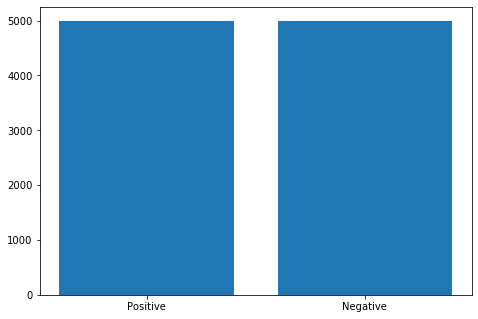

In [90]:
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

print(positive_tokens_for_model)
print(negative_tokens_for_model)

pos_count=0
for tweet_dict in positive_tokens_for_model:
    pos_count+=1

neg_count=0
for tweet_dict in negative_tokens_for_model:
    neg_count+=1

fig = plt.figure()
tweet_type = ['Positive','Negative']
tweet_counts = [pos_count,neg_count]
ax = fig.add_axes([0,0,1,1])
ax.bar(tweet_type,tweet_counts)
plt.show()

In [79]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

print(positive_dataset)
print(negative_dataset)

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

#70:30 split
train_data = dataset[:7000]
test_data = dataset[7000:]   

print(train_data)
print(test_data)

 ':(': True}, 'Negative'), ({'scurri': True, 'agile': True, '#shipping': True, 'solution': True, 'available': True, 'market': True, 'book': True, 'free': True, 'demo': True, ':-)': True, '#retail': True, '#delivery': True, '#sme': True}, 'Positive'), ({'sheriff': True, 'see': True, 'aaaaaaaaaaa': True, 'aaaaages': True, ':(': True}, 'Negative'), ({'happy': True, 'friday': True, 'everyone': True, ':)': True, 'big': True, '#followfriday': True}, 'Positive'), ({'welcome': True, ':)': True}, 'Positive'), ({'hi': True, 'dark': True, 'angel': True, 'mochamichelle': True, ':)': True, 'wanna': True, 'get': True, 'iph': True, '0ne': True, '6': True, 'free': True, 'simply': True, 'go': True, 'check': True, 'bi0': True, 'thx': True}, 'Positive'), ({'didnt': True, 'take': True, 'photo': True, ':-(': True}, 'Negative'), ({'10': True, 'loner': True, 'side': True, 'please': True, ':)': True}, 'Positive'), ({"we've": True, 'receive': True, 'payment': True, 'order': True, 'process': True, ':)': True, '

In [80]:
classifier = NaiveBayesClassifier.train(train_data)

In [81]:
print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

Accuracy is: 0.9933333333333333
Most Informative Features
                      :( = True           Negati : Positi =   2072.9 : 1.0
                      :) = True           Positi : Negati =    995.2 : 1.0
                follower = True           Positi : Negati =     20.2 : 1.0
                     bam = True           Positi : Negati =     19.7 : 1.0
                     x15 = True           Negati : Positi =     19.0 : 1.0
                     sad = True           Negati : Positi =     18.3 : 1.0
               community = True           Positi : Negati =     15.7 : 1.0
                 welcome = True           Positi : Negati =     15.3 : 1.0
                      aw = True           Negati : Positi =     13.0 : 1.0
                followed = True           Negati : Positi =     12.6 : 1.0
None
